In [18]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

ERROR! Session/line number was not unique in database. History logging moved to new session 1354


In [19]:
csv_path='static/data/BBG_price_data.csv'

In [20]:
df = pd.read_csv(csv_path)
df

,Date,Corn Price,Wheat Price,Soybean Price,Cotton Price,Live Cattle,Soy Oil,Crush Margin,Soybean meal
0,1/4/10,418.50,557.75,1049.50,76.00,85.375,37.73,NaN,NaN
1,1/5/10,418.75,553.00,1052.25,73.12,86.325,37.54,NaN,NaN
2,1/6/10,421.75,567.25,1050.50,73.55,85.950,37.70,NaN,NaN
3,1/7/10,417.50,557.75,1017.75,72.89,85.925,36.62,0.99,326.5
4,1/8/10,423.00,568.50,1013.00,72.44,85.825,36.49,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2896,7/2/21,697.25,645.75,1451.75,86.03,122.000,NaN,NaN,NaN
2897,7/6/21,656.00,620.00,1363.75,86.38,122.400,71.12,NaN,NaN
2898,7/7/21,652.50,614.75,1386.50,86.63,120.600,NaN,NaN,NaN
2899,7/8/21,638.00,612.25,1390.25,85.88,119.275,NaN,3.12,362.1


In [21]:
#!pip install psycopg2

In [22]:
from sqlalchemy import create_engine
import psycopg2 
con_str = 'postgres:myAkina93!@database-1.c6qqzgohsabf.us-east-2.rds.amazonaws.com:5432/project2'
engine = create_engine(f'postgresql://{con_str}')

In [23]:
df.to_sql(name='price_raw_data', con=engine, if_exists='replace', index=False)

In [24]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2901 entries, 0 to 2900
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           2901 non-null   object 
 1   Corn Price     2901 non-null   float64
 2   Wheat Price    2901 non-null   float64
 3   Soybean Price  2901 non-null   float64
 4   Cotton Price   2901 non-null   float64
 5   Live Cattle    2901 non-null   float64
 6   Soy Oil        2775 non-null   float64
 7   Crush Margin   579 non-null    float64
 8   Soybean meal   580 non-null    float64
dtypes: float64(8), object(1)
memory usage: 204.1+ KB


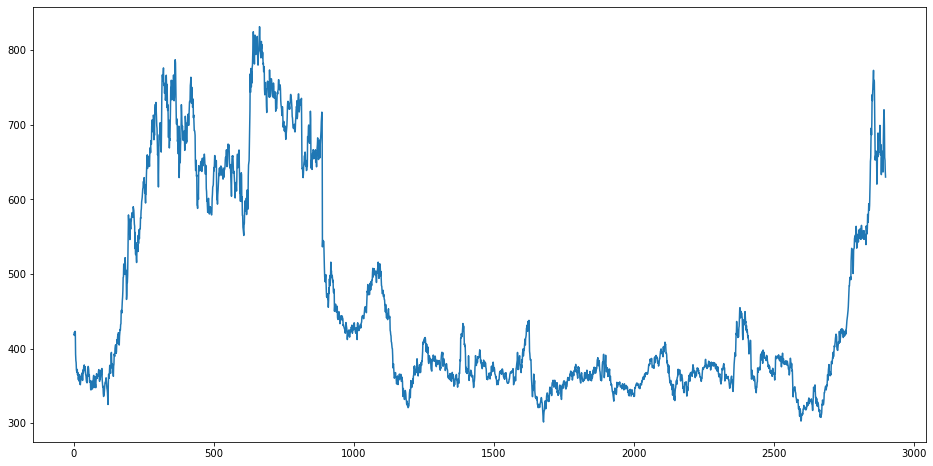

In [25]:
df["Date"]=pd.to_datetime(df.Date,format="%m/%d/%y")
# df = df.set_index('Date', drop=True) 

plt.figure(figsize=(16,8))
plt.plot(df["Corn Price"],label='Corn Price history')

In [26]:
df['WeekDay'] = df.Date.dt.day_name()
df['Month']= df.Date.dt.month_name()
df.head()

,Date,Corn Price,Wheat Price,Soybean Price,Cotton Price,Live Cattle,Soy Oil,Crush Margin,Soybean meal,WeekDay,Month
0,2010-01-04,418.50,557.75,1049.50,76.00,85.375,37.73,NaN,NaN,Monday,January
1,2010-01-05,418.75,553.00,1052.25,73.12,86.325,37.54,NaN,NaN,Tuesday,January
2,2010-01-06,421.75,567.25,1050.50,73.55,85.950,37.70,NaN,NaN,Wednesday,January
3,2010-01-07,417.50,557.75,1017.75,72.89,85.925,36.62,0.99,326.5,Thursday,January
4,2010-01-08,423.00,568.50,1013.00,72.44,85.825,36.49,NaN,NaN,Friday,January


In [27]:
seasonal_df = pd.get_dummies(df, columns=['WeekDay','Month'])
seasonal_df.head()

,Date,Corn Price,Wheat Price,Soybean Price,Cotton Price,Live Cattle,Soy Oil,Crush Margin,Soybean meal,WeekDay_Friday,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,2010-01-04,418.50,557.75,1049.50,76.00,85.375,37.73,NaN,NaN,0,...,0,0,1,0,0,0,0,0,0,0
1,2010-01-05,418.75,553.00,1052.25,73.12,86.325,37.54,NaN,NaN,0,...,0,0,1,0,0,0,0,0,0,0
2,2010-01-06,421.75,567.25,1050.50,73.55,85.950,37.70,NaN,NaN,0,...,0,0,1,0,0,0,0,0,0,0
3,2010-01-07,417.50,557.75,1017.75,72.89,85.925,36.62,0.99,326.5,0,...,0,0,1,0,0,0,0,0,0,0
4,2010-01-08,423.00,568.50,1013.00,72.44,85.825,36.49,NaN,NaN,1,...,0,0,1,0,0,0,0,0,0,0


In [28]:
seasonal_df.drop(columns=['WeekDay_Friday','Month_December'])

,Date,Corn Price,Wheat Price,Soybean Price,Cotton Price,Live Cattle,Soy Oil,Crush Margin,Soybean meal,WeekDay_Monday,...,Month_August,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,2010-01-04,418.50,557.75,1049.50,76.00,85.375,37.73,NaN,NaN,1,...,0,0,1,0,0,0,0,0,0,0
1,2010-01-05,418.75,553.00,1052.25,73.12,86.325,37.54,NaN,NaN,0,...,0,0,1,0,0,0,0,0,0,0
2,2010-01-06,421.75,567.25,1050.50,73.55,85.950,37.70,NaN,NaN,0,...,0,0,1,0,0,0,0,0,0,0
3,2010-01-07,417.50,557.75,1017.75,72.89,85.925,36.62,0.99,326.5,0,...,0,0,1,0,0,0,0,0,0,0
4,2010-01-08,423.00,568.50,1013.00,72.44,85.825,36.49,NaN,NaN,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,2021-07-02,697.25,645.75,1451.75,86.03,122.000,NaN,NaN,NaN,0,...,0,0,0,1,0,0,0,0,0,0
2897,2021-07-06,656.00,620.00,1363.75,86.38,122.400,71.12,NaN,NaN,0,...,0,0,0,1,0,0,0,0,0,0
2898,2021-07-07,652.50,614.75,1386.50,86.63,120.600,NaN,NaN,NaN,0,...,0,0,0,1,0,0,0,0,0,0
2899,2021-07-08,638.00,612.25,1390.25,85.88,119.275,NaN,3.12,362.1,0,...,0,0,0,1,0,0,0,0,0,0


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

ERROR! Session/line number was not unique in database. History logging moved to new session 1355


In [32]:
def cropLinReg(crop, startCol):
    X = seasonal_df.iloc[:,startCol:]
    Y = seasonal_df[crop]
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,test_size=0.33, random_state=1)
    model = LinearRegression()
    # Fit to model
    model.fit(X_train, Y_train)
    # predict
    predictions = model.predict(X)
    print(mean_squared_error(Y, predictions))

    # %matplotlib inline 
    fig= plt.figure(figsize=(24,12))

    plt.scatter(Y,predictions)
    plt.xlabel(crop)
    plt.ylabel(f"Predicted {crop}")
    plt.title("Price Forecast Based on Weekday and Monthly Seasonality")
    
    print (r2_score(Y, predictions))

19186.51992847294
0.004800213759386551


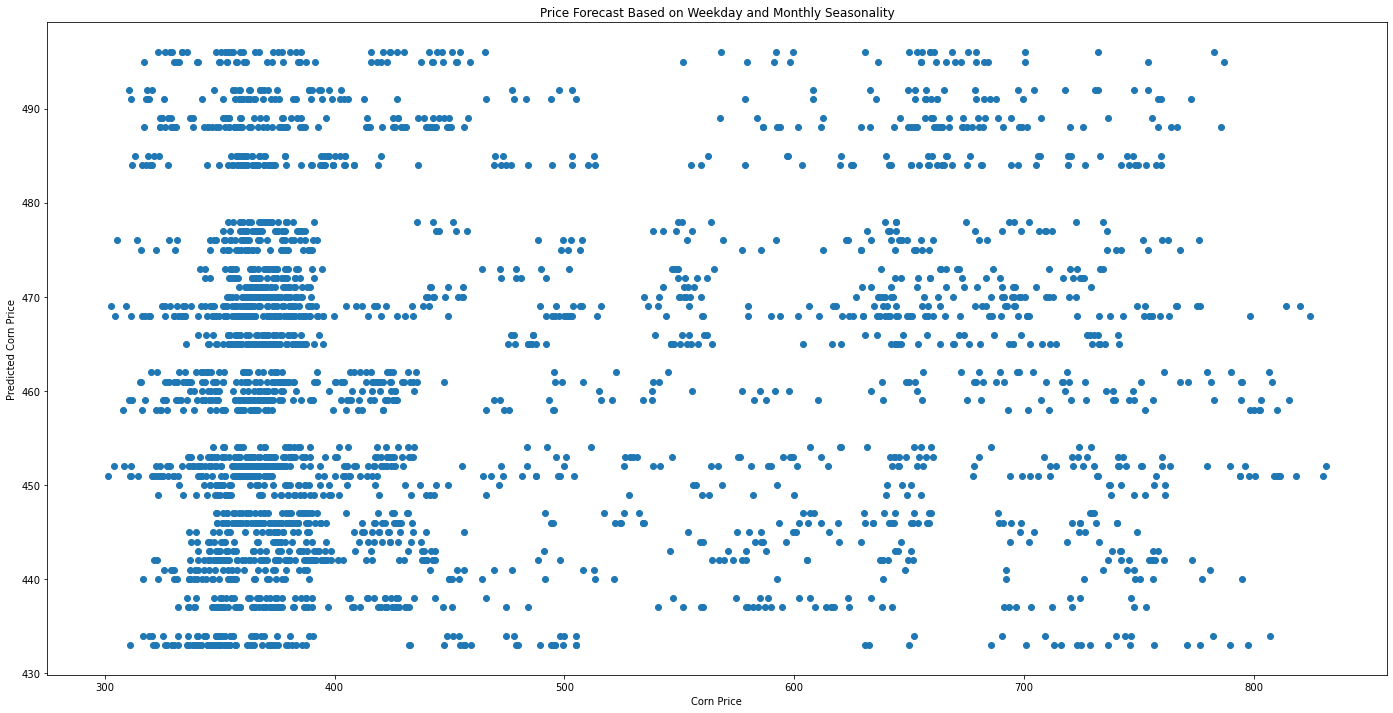

In [33]:
cropLinReg('Corn Price', 9)

19186.51992847294
0.004800213759386551


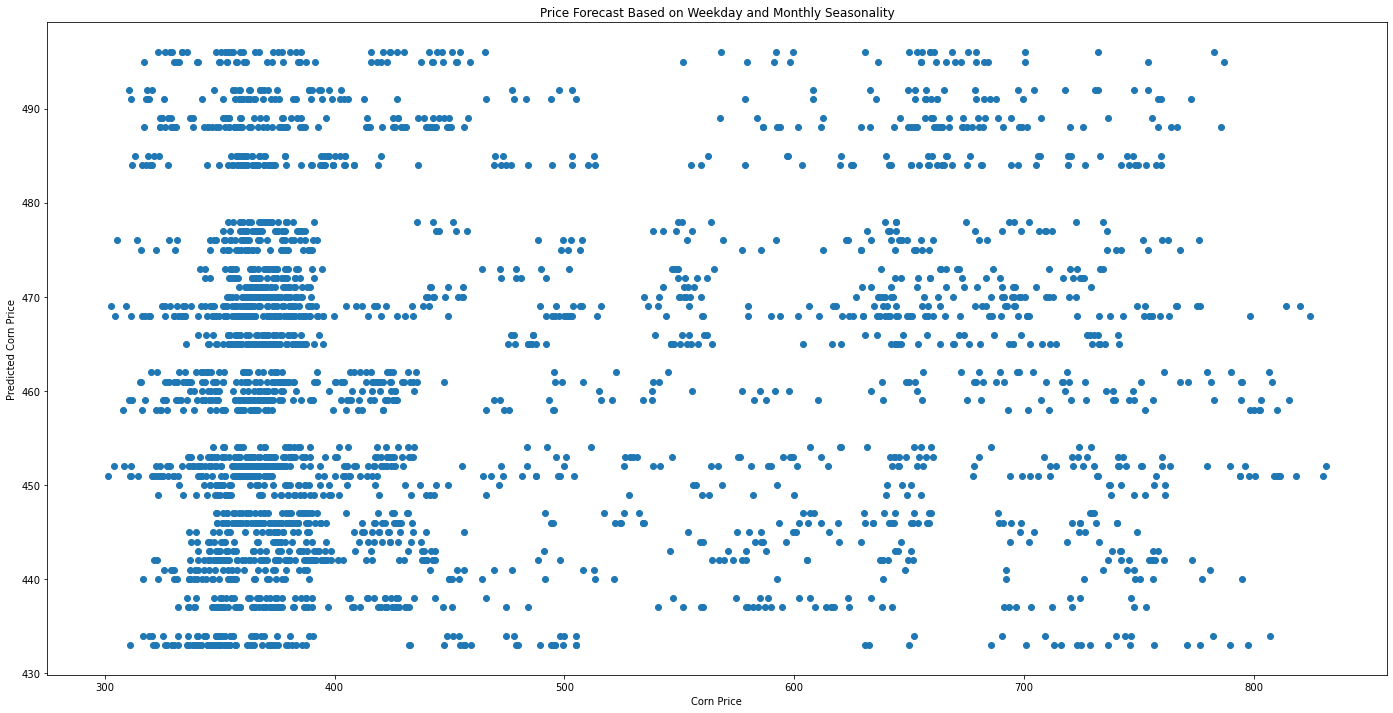

In [34]:
cropLinReg('Corn Price', 9)